<h1 align="center"><strong>Fire Risk Prediction using Machine Learning</strong></h1>

<p align="center">Project by: AOUAD AYOUB</p>


 # Importation of Python Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
import joblib

# Import scikit-learn packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# 1. Data Loading and Preprocessing


In [30]:
# Load the dataset
data = pd.read_csv('forestdata.csv')
data.head()

# Data cleaning function
def clean(rdata):
    """
    Function to clean the dataset.
    """

    # Change (.) to (_) in column names
    rdata.columns = rdata.columns.str.replace('.', '_')

    # Correct typo in 'time_of_day' column
    rdata.loc[rdata['time_of_day'] == 'morni7ng', 'time_of_day'] = 'morning'

    # One-hot encode 'time_of_day' and 'month'
    for cat in rdata['time_of_day'].unique():
        rdata[cat] = np.where(rdata['time_of_day'] == cat, 1, 0)

    for mon in rdata['month'].unique():
        rdata[f'month_{mon}'] = np.where(rdata['month'] == mon, 1, 0)

    # Drop missing values
    rdata = rdata.drop(['collector_id', 'time_of_day', 'month'], axis=1).dropna()

    # Trim DataFrame
    keep = (rdata['tree_age'] < 250) & (rdata['c_score'] < 250) & (rdata['humidity'] > 30)
    nwdata = rdata[keep]

    return nwdata

df = clean(data)

In [31]:
df.head()

,c_score,l_score,rain,tree_age,surface_litter,wind_intensity,humidity,tree_density,fire,afternoon,morning,night,month_8,month_4,month_10,month_9,month_7,month_2,month_1,month_12,month_3,month_11,month_6,month_5
0,13.11,3.421591,0.477187,34.66,6.718047,3.335635,52.0,0.69860,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,11.99,2.874611,0.212425,19.39,6.242029,3.127024,59.0,0.62020,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,12.91,2.827774,0.118141,15.75,6.397929,3.052446,60.0,0.58235,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,12.06,2.772961,0.097565,13.25,6.278146,3.114239,60.0,0.57025,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,15.06,3.271684,0.438121,47.14,6.932448,3.214831,51.0,0.71150,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 0 to 455
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c_score         441 non-null    float64
 1   l_score         441 non-null    float64
 2   rain            441 non-null    float64
 3   tree_age        441 non-null    float64
 4   surface_litter  441 non-null    float64
 5   wind_intensity  441 non-null    float64
 6   humidity        441 non-null    float64
 7   tree_density    441 non-null    float64
 8   fire            441 non-null    int64  
 9   afternoon       441 non-null    int64  
 10  morning         441 non-null    int64  
 11  night           441 non-null    int64  
 12  month_8         441 non-null    int64  
 13  month_4         441 non-null    int64  
 14  month_10        441 non-null    int64  
 15  month_9         441 non-null    int64  
 16  month_7         441 non-null    int64  
 17  month_2         441 non-null    int64  



# 2. Feature Engineering


In [33]:
# Drought Index
df['drought_index'] = df['humidity'] * (1 - df['rain'])
df['drought_index'] = (df['drought_index'] - df['drought_index'].mean()) / df['drought_index'].std()


# 3. Exploratory Data Analysis (EDA)


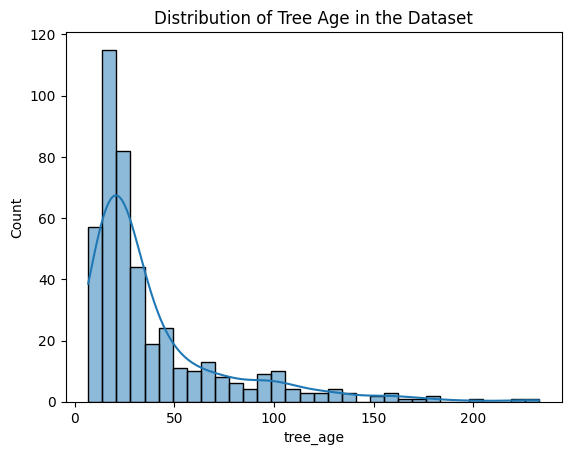

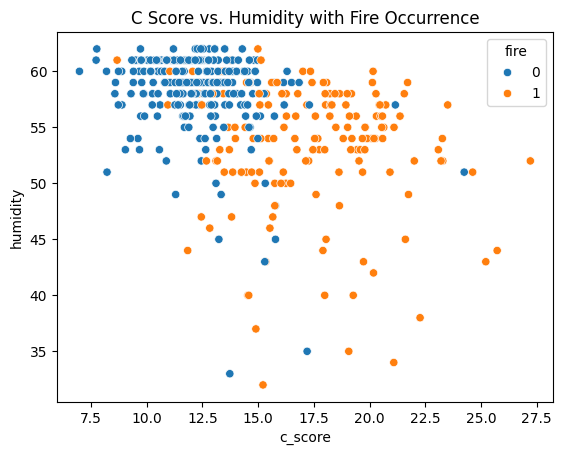

In [34]:
# Histogram of Tree Age
sns.histplot(df['tree_age'], kde=True)
plt.title('Distribution of Tree Age in the Dataset')
plt.show()

# Scatterplot of C Score vs. Humidity, Colored by Fire Occurrence
sns.scatterplot(x='c_score', y='humidity', hue='fire', data=df)
plt.title('C Score vs. Humidity with Fire Occurrence')
plt.show()

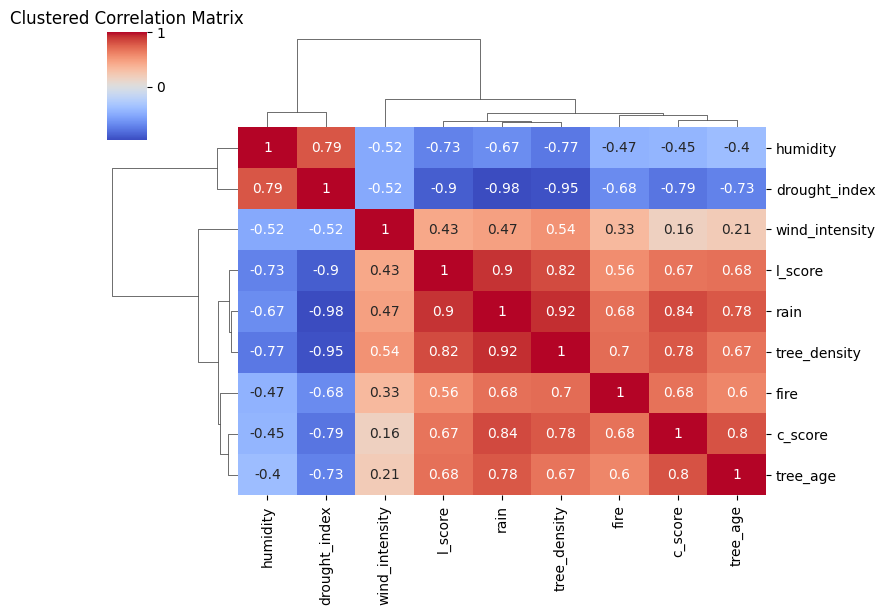

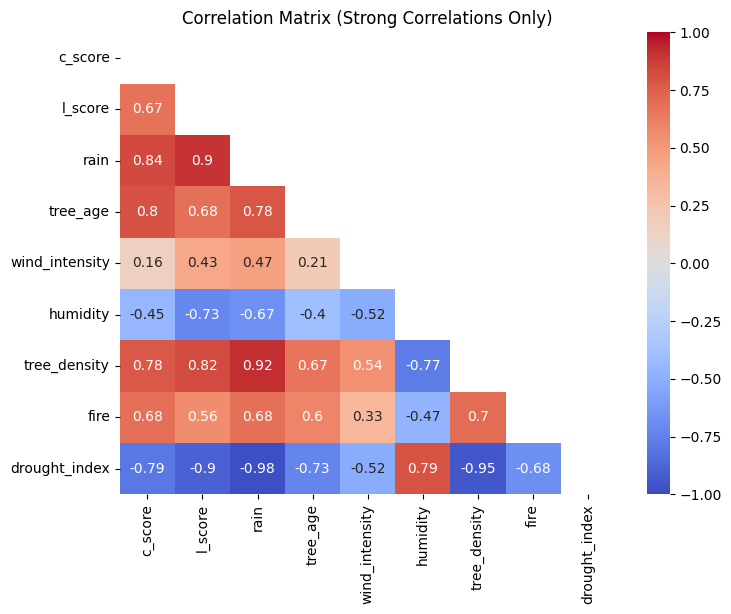

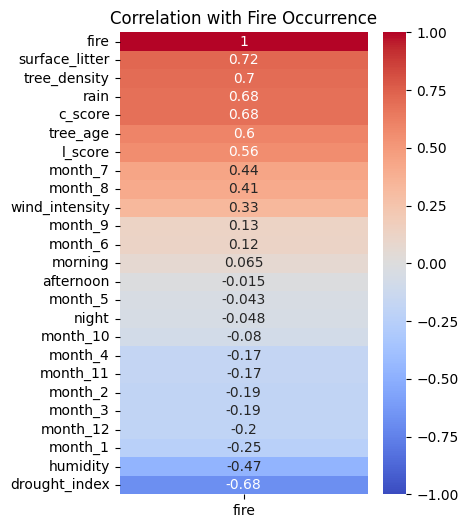

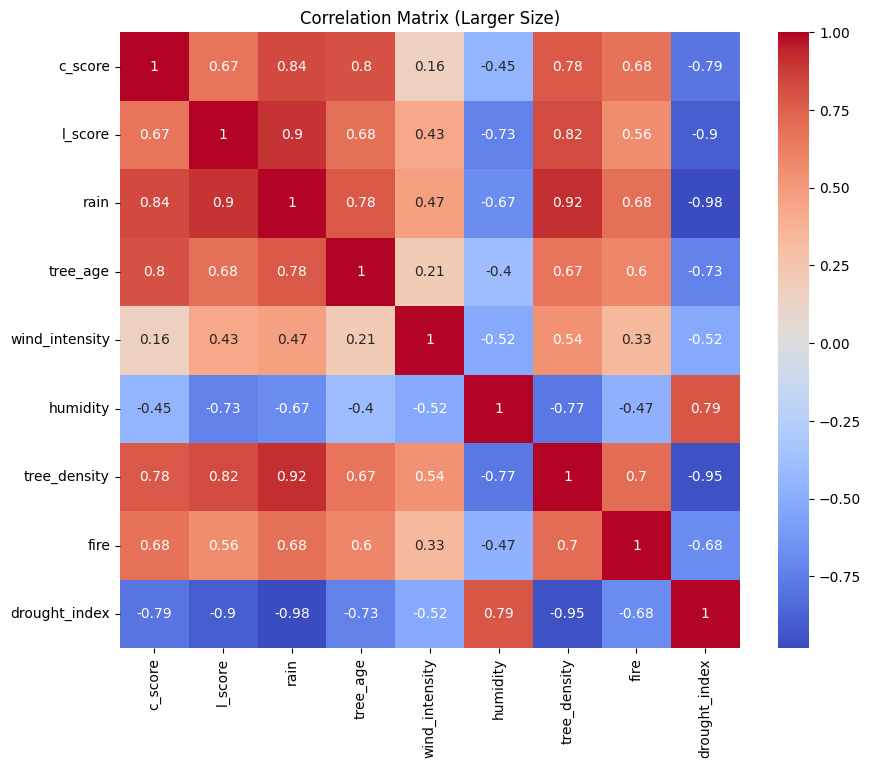

In [35]:
important_features = ['c_score', 'l_score', 'rain', 'tree_age', 'wind_intensity',
                     'humidity', 'tree_density', 'fire', 'drought_index']
corr_matrix = df[important_features].corr()

# 2. Reorder for Better Visualization:

# Clustermap (groups correlated features together)
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(8, 6))
plt.title('Clustered Correlation Matrix')
plt.show()

# 3. Emphasize Strong Correlations:

# Mask for hiding weak correlations
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Strong Correlations Only)')
plt.show()

# 4. Separate Target Variable:

# Calculate correlation with the target variable
target_corr = df.corr()['fire'].sort_values(ascending=False)
plt.figure(figsize=(4, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Fire Occurrence')
plt.show()

# 5. Adjust Figure Size:

plt.figure(figsize=(10, 8))  # Larger size for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Larger Size)')
plt.show()


# 4. Data Split and Scaling


In [36]:
# Select the target variable and features
y = df.fire
X = df.drop('fire', axis=1)

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Standardize numeric features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


# 5. Model Building and Evaluation


In [39]:
# Function to evaluate model performance(Evaluates a model using various metrics and cross-validation.)
def evaluate_model(model, X, y, cv=5):

    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    avg_cv_score = np.mean(cv_scores)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Average Cross-Validation Accuracy: {avg_cv_score:.4f}")

    # Plot Confusion Matrix using ConfusionMatrixDisplay
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
    disp.plot(cmap='Blues')  # You can customize the colormap
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.show()

----- Logistic Regression -----
Accuracy: 0.9213
Precision: 0.8750
Recall: 0.9459
F1 Score: 0.9091
ROC-AUC: 0.9249
Average Cross-Validation Accuracy: 0.9327


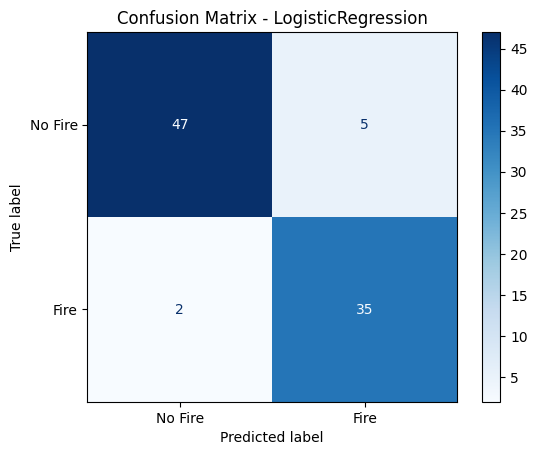

In [40]:
# 1. Logistic Regression
print("----- Logistic Regression -----")
logit = LogisticRegression()
logit.fit(X_train, y_train)
evaluate_model(logit, X_test, y_test)


----- Decision Tree -----
Accuracy: 0.8989
Precision: 0.8684
Recall: 0.8919
F1 Score: 0.8800
ROC-AUC: 0.8979
Average Cross-Validation Accuracy: 0.8882


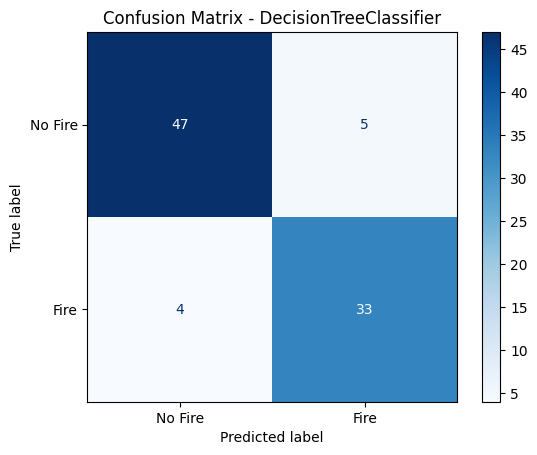

In [41]:
# 2. Decision Tree
print("\n----- Decision Tree -----")
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
evaluate_model(tree, X_test, y_test)


----- Random Forest -----
Accuracy: 0.9551
Precision: 0.9231
Recall: 0.9730
F1 Score: 0.9474
ROC-AUC: 0.9576
Average Cross-Validation Accuracy: 0.9216


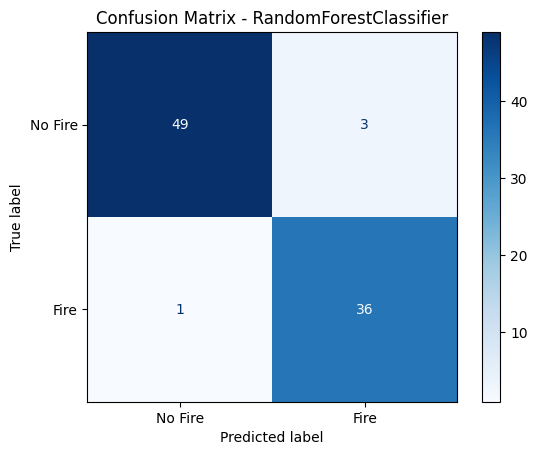

In [42]:
# 3. Random Forest
print("\n----- Random Forest -----")
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)


----- XGBoost -----
Accuracy: 0.9438
Precision: 0.9211
Recall: 0.9459
F1 Score: 0.9333
ROC-AUC: 0.9441
Average Cross-Validation Accuracy: 0.8876


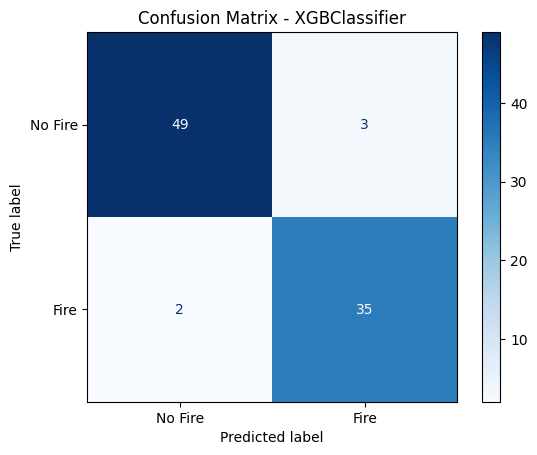

In [43]:
# 4. XGBoost
print("\n----- XGBoost -----")
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test)


----- Neural Network (MLP Classifier) -----
Accuracy: 0.8989
Precision: 0.8500
Recall: 0.9189
F1 Score: 0.8831
ROC-AUC: 0.9018
Average Cross-Validation Accuracy: 0.9438


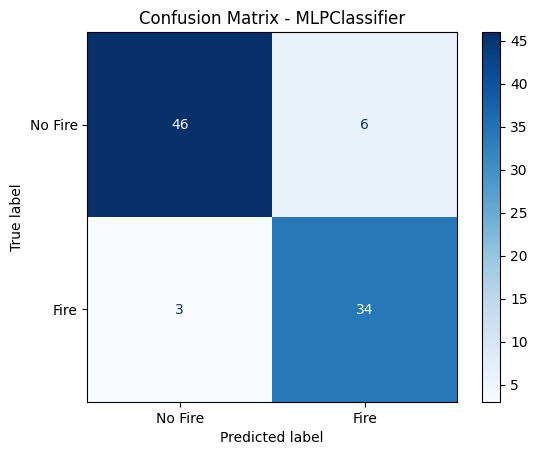

In [44]:
# 5. Neural Network
print("\n----- Neural Network (MLP Classifier) -----")
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test)

# Hyperparameter Tuning

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Best Logistic Regression Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Accuracy: 0.9326
Precision: 0.8780
Recall: 0.9730
F1 Score: 0.9231
ROC-AUC: 0.9384
Average Cross-Validation Accuracy: 0.9438


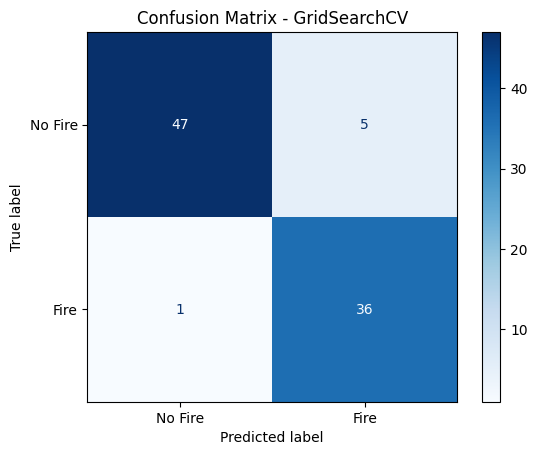

In [45]:
# Hyperparameter Tuning for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}
grid_search = GridSearchCV(logit, param_grid=param_grid, scoring='accuracy', cv=5, verbose=True)
best_log_mod = grid_search.fit(X_train, y_train)
print("Best Logistic Regression Parameters:", best_log_mod.best_params_)
evaluate_model(best_log_mod, X_test, y_test)


----- Decision Tree -----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.9213
Precision: 0.8750
Recall: 0.9459
F1 Score: 0.9091
ROC-AUC: 0.9249
Average Cross-Validation Accuracy: 0.8314


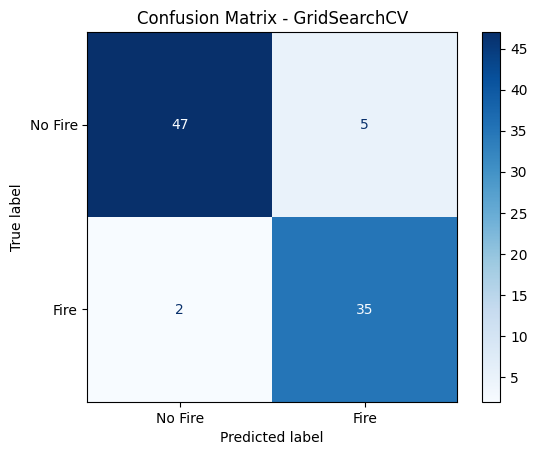

In [46]:
# Hyperparameter Tuning for Decision Tree
print("\n----- Decision Tree -----")
param_grid = {
    'max_depth': [3, 5, None],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss']
}
grid_search = GridSearchCV(tree, param_grid, scoring='accuracy', cv=5, verbose=True)
best_tree_mod = grid_search.fit(X_train, y_train)
print("Best Decision Tree Parameters:", best_tree_mod.best_params_)
evaluate_model(best_tree_mod, X_test, y_test)


----- Random Forest -----
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy: 0.9551
Precision: 0.9459
Recall: 0.9459
F1 Score: 0.9459
ROC-AUC: 0.9537
Average Cross-Validation Accuracy: 0.8993


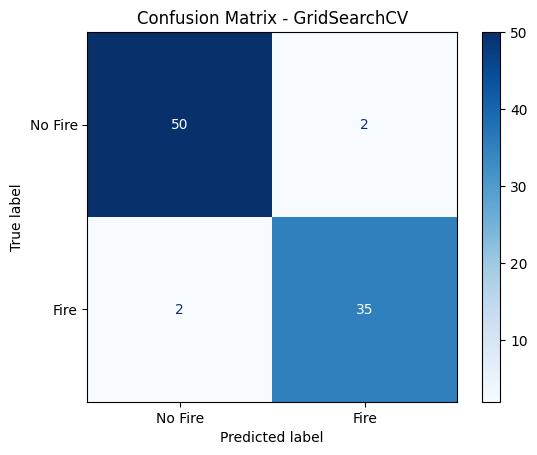

In [47]:
# Hyperparameter Tuning for Random Forest
print("\n----- Random Forest -----")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=5, verbose=True)
best_rf_mod = grid_search.fit(X_train, y_train)
print("Best Random Forest Parameters:", best_rf_mod.best_params_)
evaluate_model(best_rf_mod, X_test, y_test)


----- XGBoost -----
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.9438
Precision: 0.9211
Recall: 0.9459
F1 Score: 0.9333
ROC-AUC: 0.9441
Average Cross-Validation Accuracy: 0.8876


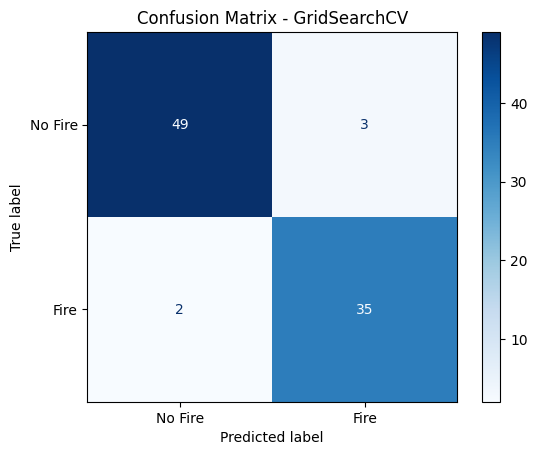

In [48]:
# Hyperparameter Tuning for XGBoost
print("\n----- XGBoost -----")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5, verbose=True)
best_xgb_mod = grid_search.fit(X_train, y_train)
print("Best XGBoost Parameters:", best_xgb_mod.best_params_)
evaluate_model(best_xgb_mod, X_test, y_test)


----- Neural Network (MLP Classifier) -----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Neural Network Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (10, 50, 10), 'learning_rate_init': 0.05, 'solver': 'adam'}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy: 0.9213
Precision: 0.8571
Recall: 0.9730
F1 Score: 0.9114
ROC-AUC: 0.9288
Average Cross-Validation Accuracy: 0.9660


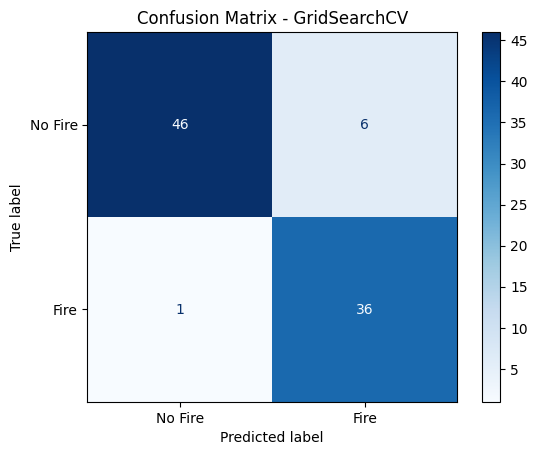

In [49]:
# Hyperparameter Tuning for Neural Network
print("\n----- Neural Network (MLP Classifier) -----")
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (10, 50, 10)],
    'activation': ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01, 0.05],
    'solver': ['sgd', 'adam'],
}
# Set n_jobs to 1 to disable parallel processing for GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=True, n_jobs=1)
best_mlp_mod = grid_search.fit(X_train, y_train)
print("Best Neural Network Parameters:", best_mlp_mod.best_params_)
evaluate_model(best_mlp_mod, X_test, y_test)

# 6. Model Saving

In [50]:
best_model = best_mlp_mod
model_filename = 'best_model_mlp.pkl'
joblib.dump(best_model, model_filename)

print(f"Best model (Neural Network) saved to: {model_filename}")

Best model (Neural Network) saved to: best_model_mlp.pkl
